In [6]:
from pandas import read_csv
from datetime import datetime
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import pandas as pd
import collections
import seaborn as sns
import numpy as np
import tensorflow as tf

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import pickle

Using TensorFlow backend.


In [7]:
# load data
def builData():
    
    def parse(x):
        return datetime.strptime(x, '%Y-%m-%d')

    df = read_csv('inr.csv', parse_dates=['date'], date_parser=parse)

    # dataset.index.name = 'date'

    # dataset.drop('Unnamed: 0', axis=1, inplace=True)

    # mark all NA values with 0
    curr_key = ['Canadian Dollar', 'Sterling', 'INR', 'US Dollar']

    for curr in curr_key: 
        df[curr].fillna(0, inplace=True)
        df[curr] = df[curr].replace('-', 0) 
    for j in range(5):
        for curr in curr_key:
            i = 0
            for v in df[curr]:
                df[curr][i] = float(df[curr][i])
                if i < len(df[curr])-1 and df[curr][i] == 0:
                    df[curr][i] = float(df[curr][i+1])        
                i += 1


    df.info()
    print(df.head(5))
    return df

In [8]:
#df = builData()
#df.to_pickle('currency')

In [9]:
def prepareData(df):
    #creating train and test sets
    start_date = '1999-01-04'
    start = 365 * 10 #2015
    # df.columns.drop(['Unnamed: 0', 'date'])

    dataset = df.values

    dataset = np.array(sorted(dataset, key=lambda p: p[1], reverse=False))
    dataset = dataset[start:, -4:].astype(np.float64)
    print(dataset.shape)

    train_size = int(len(dataset)*0.8)

    train = dataset[:train_size, :]
    valid = dataset[train_size:, :]
    #converting dataset into x_train and y_train
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(train)
    scaled_data_test = scaler.fit_transform(valid)

    x_train, y_train = [], []
    x_test, y_test = [], []

    lookback = 30
    for i in range(lookback,len(train)):
        x_train.append(scaled_data[i-lookback:i,:])
        y_train.append(1*(scaled_data[i,:] > scaled_data[i-1,:]))
    for i in range(lookback,len(valid)):
        x_test.append(scaled_data_test[i-lookback:i,:])
        y_test.append(1*(scaled_data[i,:] > scaled_data[i-1,:]))

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.array(x_test), np.array(y_test)

    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],4))
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],4))
    print(x_train.shape)
    return x_train, y_train, x_test, y_test, scaler

In [10]:
def buildModel(x_train, y_train):
    curr_key = ['Canadian Dollar', 'Sterling', 'INR', 'US Dollar']
    i = 0
    for curr in curr_key:
        # create and fit the LSTM network
        model = Sequential()
        model.add(Dropout(0.2))
        model.add(LSTM(units=30))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='sigmoid'))
        X = x_train[:, :, i].reshape(x_train.shape[0], x_train.shape[1], 1)
        y = y_train[:, i]

        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        history = model.fit(X, y, epochs=1, batch_size=1, verbose=1)
        filename = curr + '_model.sav'
        pickle.dump(model, open(filename, 'wb'))

        i += 1
    

In [11]:
def loadModel():
    curr_key = ['Canadian Dollar', 'Sterling', 'INR', 'US Dollar']
    i = 0
    models = []
    for curr in curr_key:
        # load the model from disk
        filename = curr + '_model.sav'
        loaded_model = pickle.load(open(filename, 'rb'))
        models.append(loaded_model)
    return models

In [12]:
def predict(x_test, models):
    predict_arr = np.zeros((x_test.shape[0], len(models)))

    i = 0
    for model in models:
        X = x_test[:, :, i].reshape(x_test.shape[0], x_test.shape[1], 1)
        
        prediction = model.predict(X)
        predict_arr[:, i] = prediction.reshape(prediction.shape[0],)
        i += 1
    return predict_arr

In [13]:
def getMSE(x_train, y_train, models, scaler):
    i = 0
    mse_arr = []
    ps = y_train
    for model in models:
        X = x_train[:, :, i].reshape(x_train.shape[0], x_train.shape[1], 1)
        p = model.predict(X)
        ps[:, i] = p.reshape(p.shape[0],)
        i += 1

    y_train_inv = scaler.inverse_transform(y_train)
    predict = scaler.inverse_transform(ps)
    
    for j in range(len(models)):
        mse = mean_squared_error(y_train_inv[:, j], predict[:, j])
        mse_arr.append(mse)
    return mse_arr

In [14]:
df = pd.read_pickle('currency')
df.head(5)

,Unnamed: 0,date,Canadian Dollar,Sterling,INR,US Dollar
0,6,2019-07-31,1.4662,0.91623,76.6965,1.1151
1,7,2019-07-31,1.4662,0.91623,76.6965,1.1151
2,8,2019-07-30,1.4691,0.91653,76.7575,1.1154
3,9,2019-07-29,1.4645,0.90443,76.474,1.1119
4,10,2019-07-26,1.468,0.89633,76.74,1.1138


In [15]:
x_train, y_train, x_test, y_test, scaler = prepareData(df)

(1927, 4)
(1511, 30, 4)


In [16]:
buildModel(x_train, y_train)

Epoch 1/1
1511/1511 [==============================] - 16s 10ms/step - loss: 0.6951 - accuracy: 0.4970
Epoch 1/1
1511/1511 [==============================] - 16s 10ms/step - loss: 0.6952 - accuracy: 0.5261
Epoch 1/1
1511/1511 [==============================] - 16s 11ms/step - loss: 0.6923 - accuracy: 0.5261
Epoch 1/1
1511/1511 [==============================] - 16s 10ms/step - loss: 0.6955 - accuracy: 0.4937


In [13]:
models = loadModel()

In [14]:
predict_arr = predict(x_test, models)

[0.0, 0.0, 0.0, 0.0]


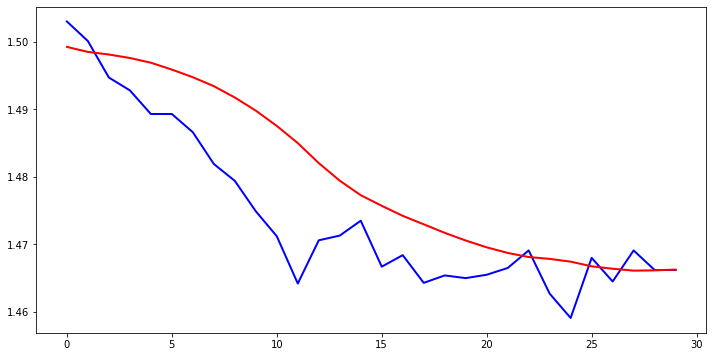

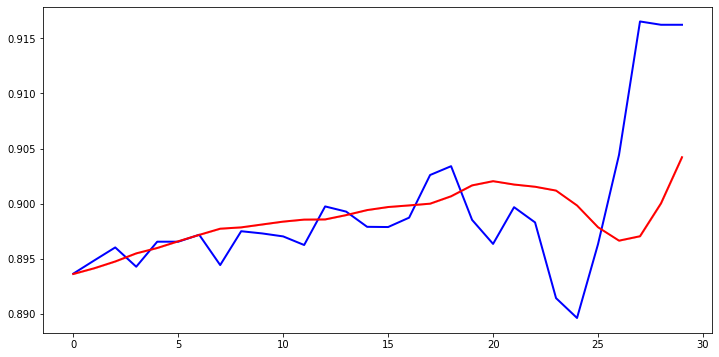

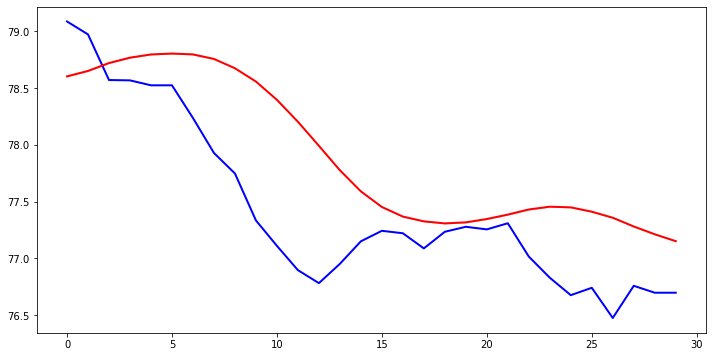

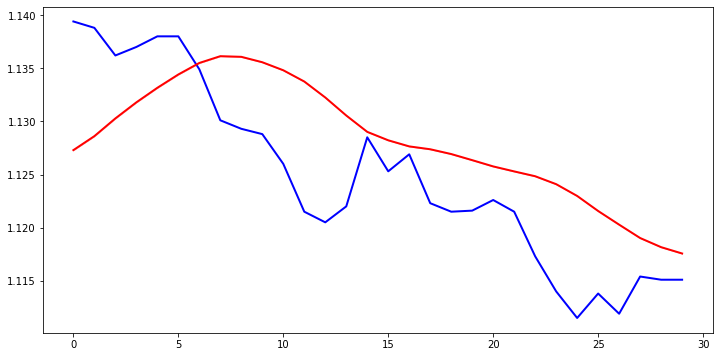

In [15]:
y_test_inv = scaler.inverse_transform(y_test)
predict = scaler.inverse_transform(predict_arr)
curr_key = ['Canadian Dollar', 'Sterling', 'INR', 'US Dollar']
mse_arr = getMSE(x_train, y_train, models, scaler)
print(mse_arr)
horizon = 30
for i in range(len(curr_key)):
    xs = np.arange(int(horizon))
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.plot(xs, y_test_inv[-horizon:, i], label='Real ' + curr_key[i], lw=2, color='blue')
    ax.plot(xs, predict[-horizon:, i], label='Forecast ' + curr_key[i], lw=2, color='red')

    rmse = mse_arr[i]
    rmse_max = [float(p) + float(rmse)/2 for p in predict[:, i]]
    rmse_min = [float(p) - float(rmse)/2 for p in predict[:, i]]
    
    ax.fill_between(xs, rmse_max[-horizon:], rmse_min[-horizon:], color='red', alpha=0.2)
    plt.show()

In [16]:
def getActions(Delta, V, Cash, T):
    n = Delta.shape[1]
    t_cur = T
    t_prev = t_cur - 1
    t_next = t_cur + 1
    X_eur = Cash[t_cur, -1]
    X_new = X_eur
    A = []
    
    for c in range(n):
        action = ''
        X = 0
        X_cur = Cash[t_cur, c]

        d_prev = Delta[t_prev, c]
        d_cur = Delta[t_cur, c]
        d_next = Delta[t_next, c]

        if d_prev > 0 and d_cur > 0 and d_next < 0:
            action = 'BUY'

        elif d_prev > 0 and d_cur < 0 and d_next < 0:
            action = 'BUY'

        elif d_prev < 0 and d_cur < 0 and d_next > 0:
            action = 'SELL'

        elif d_prev < 0 and d_cur > 0 and d_next > 0:
            action = 'SELL'
        A.append([action, X])
    
    return A

In [17]:
curr_key = ['Canadian Dollar', 'Sterling', 'INR', 'US Dollar', 'eur']
horizon=150

V = predict[-horizon-1:, :]
y = y_test_inv[-horizon-1:, :]
V[0, :] = y_test_inv[-horizon-1, :]
n = V.shape[1]
initial_cash = 1000

Cash = np.zeros((horizon+1, n + 1))
Cash[0, :] = [initial_cash, initial_cash, initial_cash, initial_cash, initial_cash]

Delta = np.zeros((horizon + 1, n))
for c in range(n):
    for t in range(1, horizon + 1):
        Delta[t, c] = V[t, c] - V[t - 1, c]

for t in range(horizon-1):
    A = getActions(Delta, V, Cash, t + 1)
    Cash[t+1, :] = Cash[t, :]
    b = 0
    c = 0
    
    print('Jour ', t)
    for a in A:        
        if a[0] == 'SELL' and Cash[t, c] > 0:
            Cash[t+1, c] = Cash[t+1, c] -  Cash[t+1, c]
            Cash[t+1, -1] = Cash[t + 1, -1] + Cash[t, c]/y[t, c]
            print(str(a[0]) + ' ' + str(Cash[t, c]) + ' ' + str(curr_key[c]))
            print('Euro 1', Cash[t+1, -1])
        if a[0] == 'BUY':
            b += 1
        c += 1
          
    c = 0    
    for a in A:
            
        if a[0] == 'BUY' and Cash[t+1, -1] > 0:
            print('Euro 2', Cash[t+1, -1])
            print(str(a[0]) + ' ' + str(Cash[t + 1, -1]/b) + ' ' + str(curr_key[c]))
            Cash[t+1, c] = Cash[t, c] + Cash[t + 1, -1]*y[t, c]/b
            Cash[t+1, -1] = Cash[t + 1, -1] - Cash[t + 1, -1]/b
        
            
        
        c += 1
    
    print('Actions end of day', A)
    print(Cash[t+1, :])
        

        



Jour  0
Actions end of day [['', 0], ['', 0], ['', 0], ['', 0]]
[1000. 1000. 1000. 1000. 1000.]
Jour  1
SELL 1000.0 INR
Euro 1 1012.4013319030464
SELL 1000.0 US Dollar
Euro 1 1885.382562806582
Euro 2 1885.382562806582
BUY 1885.382562806582 Canadian Dollar
Actions end of day [['BUY', 0], ['', 0], ['SELL', 0], ['SELL', 0]]
[3860.50242429 1000.            0.            0.            0.        ]
Jour  2
SELL 1000.0 Sterling
Euro 1 1105.913318514095
Actions end of day [['', 0], ['SELL', 0], ['', 0], ['', 0]]
[3860.50242429    0.            0.            0.         1105.91331851]
Jour  3
Euro 2 1105.913318514095
BUY 1105.913318514095 Sterling
Actions end of day [['', 0], ['BUY', 0], ['', 0], ['', 0]]
[3860.50242429  995.48787366    0.            0.            0.        ]
Jour  4
Actions end of day [['', 0], ['BUY', 0], ['', 0], ['', 0]]
[3860.50242429  995.48787366    0.            0.            0.        ]
Jour  5
Actions end of day [['', 0], ['', 0], ['', 0], ['BUY', 0]]
[3860.50242429  99

In [137]:
def G(Delta):
    g = 0
    n, m = Delta.shape[0].shape[0], Delta.shape[0].shape[1]
    for k in range(1, n):
        for cc in range(m):
            g += Delta[k, cc]
    return g

In [138]:
def cost(M, P):
    return -g(M, P)**2

In [139]:
#### Note pour plus tard: dg a 30,4 dimension mais g a une
## Définir fonction gain avec deltas
def regGain(Delta, P):
    n, m = Delta.shape[0], Delta.shape[1]
    g = np.zeros((1, m*m))
    for k in range(1, n):
        for c in range(m*m):
            
            g[k, 0] = 1 - P[k, c1]/P[k, c2]
    return g


In [140]:
def regCost(Delta, P):
    return regGain(Delta, P)

In [141]:
# Our initinal guess
horizon=30
P = predict[-horizon:, :]
print(P.shape)
alpha = .1
horizon=30

epoch = 10000

grad = P
print(grad.shape)
m = Delta.shape[1]
Delta = np.random.rand(30, m*m)

# Run the gradient
for i in range(epoch):
    current_M = M + alpha*regCost(Delta, P)
    grad = current_M
    M = current_M
    
    g = G(M, P)

print(g)
print(M)

(30, 4)
(30, 4)
5226.799302688013
[[ 1.00000000e+01  1.00000000e+01  1.00000000e+01  1.00000000e+01]
 [ 2.28659212e+03  2.28652155e+03  2.28620447e+03  2.28648479e+03]
 [-1.92407149e+00 -1.41554777e+00 -1.97339457e+00 -1.69783322e+00]
 [-1.70172484e+00 -1.29336489e+00 -1.77497188e+00 -1.65422022e+00]
 [-1.13848039e+00 -9.78538713e-01 -1.08097851e+00 -3.38492910e-01]
 [-8.94131871e-01 -1.91503089e-01 -8.19179660e-01 -4.28427136e-01]
 [-3.99494756e-01 -5.30174833e-01 -6.58798647e-01 -5.71441201e-01]
 [ 2.89823248e-01  7.43046469e-02  2.21168194e-01  2.19013441e-01]
 [ 2.21235226e+00  2.08092585e+00  2.16657709e+00  1.45663841e+00]
 [ 1.91916640e+00  1.95418806e+00  2.35348556e+00  1.54999182e+00]
 [ 2.38935716e+00  2.54904399e+00  2.64118356e+00  2.29916988e+00]
 [ 2.43114311e+00  3.12663788e+00  3.02142478e+00  2.34503261e+00]
 [ 3.80143211e+00  4.11402125e+00  3.31922906e+00  3.92524680e+00]
 [ 2.75340581e+00  2.65071572e+00  3.10997112e+00  3.08196723e+00]
 [ 1.80880101e+00  1.7552586